# Two-Link Manipulator Demo

This notebook demonstrates all controllers for the discrete-time two-link planar manipulator.

## Model Specification (from Symbolic_control_lecture-7.pdf)

**Lagrangian Dynamics:**
$$M(\theta)\ddot{\theta} + C(\theta,\dot{\theta})\dot{\theta} + g(\theta) = \tau$$

**Discrete-time (Euler):**
$$x(t+1) = x(t) + \tau \cdot f(x(t), u(t))$$

- State: $x = [\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2]$
- Input: $u = [\tau_1, \tau_2]$ (joint torques)
- Parameters: $m_1 = m_2 = 1.0$ kg, $\ell_1 = \ell_2 = 0.5$ m

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from models.manipulator import TwoLinkManipulator
from controllers.manipulator import (
    ComputedTorqueController,
    PDGravityCompensation,
    BacksteppingController,
    ManipulatorLQRController
)
from sim.simulator import Simulator

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

## 1. Setup Model and Configuration

In [2]:
# Create model
model = TwoLinkManipulator(tau=0.01)  # Small timestep for stiff dynamics
print(f"Model: {model}")
print(f"Physical parameters:")
print(f"  Link masses: m1={model.m1} kg, m2={model.m2} kg")
print(f"  Link lengths: l1={model.l1} m, l2={model.l2} m")
print(f"  Gravity: g={model.g_acc} m/s^2")
print(f"\nState bounds: {model.x_bounds}")
print(f"Input bounds (torque): {model.u_bounds}")

# Configuration
x0 = np.array([0.0, 0.0, 0.0, 0.0])  # Start at hanging position
target = np.array([np.pi/4, np.pi/4, 0.0, 0.0])  # Go to 45-45 degree config
T = 3.0  # Simulation time (seconds)

print(f"\nStart: theta1={np.degrees(x0[0]):.1f} deg, theta2={np.degrees(x0[1]):.1f} deg")
print(f"Target: theta1={np.degrees(target[0]):.1f} deg, theta2={np.degrees(target[1]):.1f} deg")

Model: TwoLinkManipulator(tau=0.01)
Physical parameters:
  Link masses: m1=1.0 kg, m2=1.0 kg
  Link lengths: l1=0.5 m, l2=0.5 m
  Gravity: g=9.81 m/s^2

State bounds: [[ -3.14159265   3.14159265]
 [ -3.14159265   3.14159265]
 [-10.          10.        ]
 [-10.          10.        ]]
Input bounds (torque): [[-10.  10.]
 [-10.  10.]]

Start: theta1=0.0 deg, theta2=0.0 deg
Target: theta1=45.0 deg, theta2=45.0 deg


## 2. Visualization Helper

In [3]:
def plot_arm_config(ax, model, theta, color='blue', alpha=1.0, label=None):
    """Plot manipulator arm configuration."""
    p1, p2 = model.forward_kinematics(theta)
    
    # Draw links
    ax.plot([0, p1[0]], [0, p1[1]], 'o-', color=color, linewidth=3, 
            markersize=8, alpha=alpha, label=label)
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'o-', color=color, linewidth=3, 
            markersize=8, alpha=alpha)
    
    # Mark end-effector
    ax.plot(p2[0], p2[1], 's', color=color, markersize=10, alpha=alpha)

def plot_end_effector_trajectory(ax, model, states, color='blue', label=None):
    """Plot end-effector path."""
    positions = np.array([model.forward_kinematics(s[:2])[1] for s in states])
    ax.plot(positions[:, 0], positions[:, 1], '-', color=color, 
            linewidth=1.5, label=label)

## 3. Computed Torque Controller

Feedback linearization using the manipulator dynamics:

$$\tau = M(\theta)(\ddot{\theta}_d + K_p e + K_d \dot{e}) + C(\theta,\dot{\theta})\dot{\theta} + g(\theta)$$

This cancels the nonlinear dynamics, resulting in linear error dynamics.

In [8]:
# Computed Torque Controller
ct_ctrl = ComputedTorqueController(name="ComputedTorque")
ct_ctrl.set_model(model)
ct_ctrl.set_target(target)

# Stability analysis
stability = ct_ctrl.analyze_stability()
print("Computed Torque Controller:")
print(f"  Gains: Kp={ct_ctrl._Kp}, Kd={ct_ctrl._Kd}")
print(f"  Closed-loop poles: {stability.get('poles', 'N/A')}")
print(f"  Stable: {stability.get('is_stable', True)}")

# Simulate
sim = Simulator(model, ct_ctrl, disturbance_mode='random', seed=42)
ct_result = sim.run(x0, T, target)

final_error = np.linalg.norm(ct_result.states[-1, :2] - target[:2])
print(f"\nFinal joint angle error: {np.degrees(final_error):.4f} deg")

Computed Torque Controller:
  Gains: Kp=[[100.   0.]
 [  0. 100.]], Kd=[[20.  0.]
 [ 0. 20.]]
  Closed-loop poles: N/A
  Stable: True

Final joint angle error: 0.2760 deg


## 4. PD with Gravity Compensation

Simpler controller that only compensates for gravity:

$$\tau = K_p e + K_d \dot{e} + g(\theta)$$

**Lyapunov Function:** 
$$V = \frac{1}{2}\dot{\theta}^T M(\theta)\dot{\theta} + \frac{1}{2}e^T K_p e + U_g(\theta)$$

In [11]:
# PD + Gravity Compensation
pdg_ctrl = PDGravityCompensation( name="PD+Gravity")
pdg_ctrl.set_model(model)
pdg_ctrl.set_target(target)

# Stability
stability = pdg_ctrl.analyze_stability()
print("PD with Gravity Compensation:")
print(f"  Gains: Kp={pdg_ctrl._Kp}, Kd={pdg_ctrl._Kd}")
print(f"  Lyapunov-based stability: {stability.get('lyapunov_stable', True)}")

# Simulate
sim = Simulator(model, pdg_ctrl, disturbance_mode='random', seed=42)
pdg_result = sim.run(x0, T, target)

final_error = np.linalg.norm(pdg_result.states[-1, :2] - target[:2])
print(f"\nFinal joint angle error: {np.degrees(final_error):.4f} deg")

PD with Gravity Compensation:
  Gains: Kp=[[50.  0.]
 [ 0. 50.]], Kd=[[10.  0.]
 [ 0. 10.]]
  Lyapunov-based stability: True

Final joint angle error: 9.6235 deg


## 5. Backstepping Controller

Recursive Lyapunov-based design:

1. Define virtual control for position subsystem
2. Design torque to track virtual control

Provides provable stability guarantees.

In [12]:
# Backstepping Controller
bs_ctrl = BacksteppingController(name="Backstepping")
bs_ctrl.set_model(model)
bs_ctrl.set_target(target)

# Stability
stability = bs_ctrl.analyze_stability()
print("Backstepping Controller:")
print(f"  Gains: k1={bs_ctrl.k1}, k2={bs_ctrl.k2}")
print(f"  Lyapunov certificate: {stability.get('has_lyapunov', True)}")

# Simulate
sim = Simulator(model, bs_ctrl, disturbance_mode='random', seed=42)
bs_result = sim.run(x0, T, target)

final_error = np.linalg.norm(bs_result.states[-1, :2] - target[:2])
print(f"\nFinal joint angle error: {np.degrees(final_error):.4f} deg")

Backstepping Controller:
  Gains: k1=5.0, k2=10.0
  Lyapunov certificate: True

Final joint angle error: 0.2041 deg


## 6. LQR Controller (Linearized)

LQR applied to linearized dynamics around the target configuration.

$$\tau = -K(x - x^*) + g(\theta^*)$$

In [13]:
# LQR Controller
lqr_ctrl = ManipulatorLQRController(name="ManipLQR")
lqr_ctrl.set_model(model)
lqr_ctrl.set_target(target)

print("Manipulator LQR Controller:")
print(f"  Designed around target configuration")

# Simulate
sim = Simulator(model, lqr_ctrl, disturbance_mode='random', seed=42)
lqr_result = sim.run(x0, T, target)

# Analyze stability
stability = lqr_ctrl.analyze_stability()
print(f"  Local stability: {stability.get('is_locally_stable', True)}")

final_error = np.linalg.norm(lqr_result.states[-1, :2] - target[:2])
print(f"\nFinal joint angle error: {np.degrees(final_error):.4f} deg")

Manipulator LQR Controller:
  Designed around target configuration
  Local stability: True

Final joint angle error: 0.3215 deg


## 7. Controller Comparison

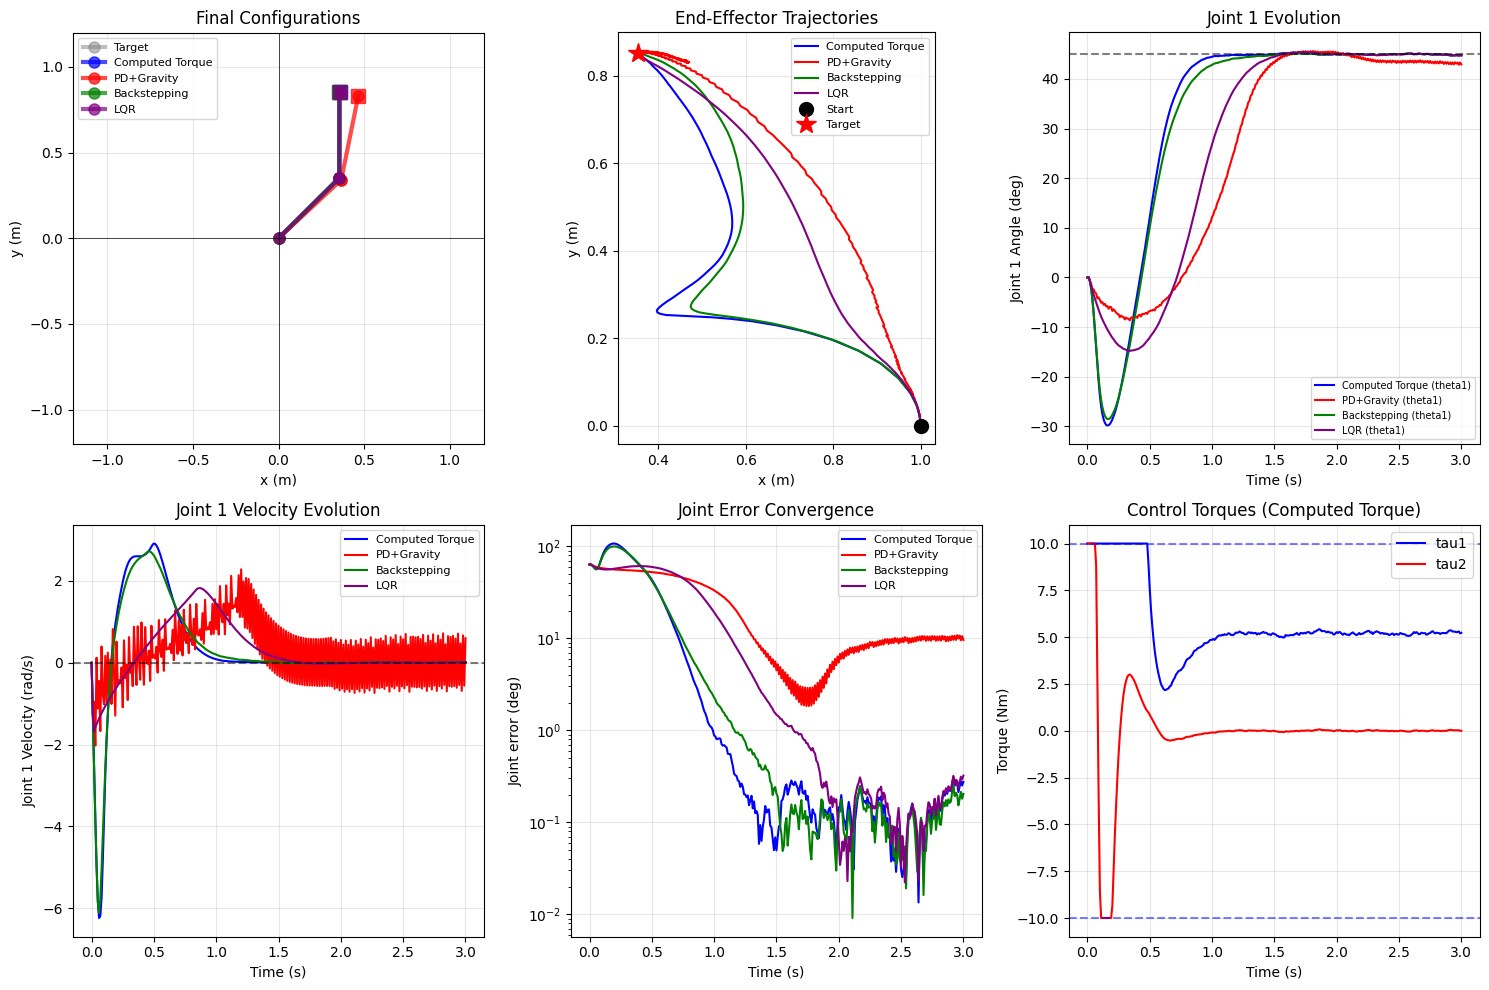


Performance Summary:
---------------------------------------------------------------------------
Controller         Final Angle Err    Final Vel Err      Torque Energy     
---------------------------------------------------------------------------
Computed Torque    0.2760             0.0210             132.5661          
PD+Gravity         9.6235             1.9593             452.9958          
Backstepping       0.2041             0.0205             127.1847          
LQR                0.3215             0.0144             146.5919          


In [14]:
# Collect all results
results = [ct_result, pdg_result, bs_result, lqr_result]
labels = ['Computed Torque', 'PD+Gravity', 'Backstepping', 'LQR']
colors = ['blue', 'red', 'green', 'purple']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Arm configurations at end
ax = axes[0, 0]
# Draw target config
plot_arm_config(ax, model, target[:2], color='gray', alpha=0.5, label='Target')
# Draw final configs
for result, label, color in zip(results, labels, colors):
    plot_arm_config(ax, model, result.states[-1, :2], color=color, alpha=0.7, label=label)
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Final Configurations')
ax.legend(loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.axhline(0, color='k', linewidth=0.5)
ax.axvline(0, color='k', linewidth=0.5)

# End-effector trajectories
ax = axes[0, 1]
target_ee = model.forward_kinematics(target[:2])[1]
start_ee = model.forward_kinematics(x0[:2])[1]
for result, label, color in zip(results, labels, colors):
    plot_end_effector_trajectory(ax, model, result.states, color=color, label=label)
ax.plot(start_ee[0], start_ee[1], 'ko', markersize=10, label='Start')
ax.plot(target_ee[0], target_ee[1], 'r*', markersize=15, label='Target')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('End-Effector Trajectories')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Joint angles
ax = axes[0, 2]
for result, label, color in zip(results, labels, colors):
    ax.plot(result.time, np.degrees(result.states[:, 0]), '-', 
            color=color, linewidth=1.5, label=f'{label} (theta1)')
ax.axhline(np.degrees(target[0]), color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Joint 1 Angle (deg)')
ax.set_title('Joint 1 Evolution')
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# Joint velocities
ax = axes[1, 0]
for result, label, color in zip(results, labels, colors):
    ax.plot(result.time, result.states[:, 2], '-', 
            color=color, linewidth=1.5, label=label)
ax.axhline(0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Joint 1 Velocity (rad/s)')
ax.set_title('Joint 1 Velocity Evolution')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Position error convergence
ax = axes[1, 1]
for result, label, color in zip(results, labels, colors):
    joint_errors = np.linalg.norm(result.states[:, :2] - target[:2], axis=1)
    ax.semilogy(result.time, np.degrees(joint_errors) + 1e-6, '-', 
                color=color, linewidth=1.5, label=label)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Joint error (deg)')
ax.set_title('Joint Error Convergence')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Control torques (first controller)
ax = axes[1, 2]
ax.plot(ct_result.time, ct_result.inputs[:, 0], 'b-', label='tau1')
ax.plot(ct_result.time, ct_result.inputs[:, 1], 'r-', label='tau2')
ax.axhline(model.u_bounds[0, 0], color='b', linestyle='--', alpha=0.5)
ax.axhline(model.u_bounds[0, 1], color='b', linestyle='--', alpha=0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Torque (Nm)')
ax.set_title('Control Torques (Computed Torque)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Performance summary
print("\nPerformance Summary:")
print("-" * 75)
print(f"{'Controller':<18} {'Final Angle Err':<18} {'Final Vel Err':<18} {'Torque Energy':<18}")
print("-" * 75)
for result, label in zip(results, labels):
    angle_err = np.degrees(np.linalg.norm(result.states[-1, :2] - target[:2]))
    vel_err = np.linalg.norm(result.states[-1, 2:] - target[2:])
    energy = result.compute_metrics()['input_energy']
    print(f"{label:<18} {angle_err:<18.4f} {vel_err:<18.4f} {energy:<18.4f}")

## 8. Animation of Best Controller

In [15]:
# Create animation of the computed torque controller
fig, ax = plt.subplots(figsize=(8, 8))

# Setup
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Two-Link Manipulator - Computed Torque Control')

# Draw target configuration (ghost)
p1_target, p2_target = model.forward_kinematics(target[:2])
ax.plot([0, p1_target[0], p2_target[0]], [0, p1_target[1], p2_target[1]], 
        'o--', color='gray', linewidth=2, markersize=6, alpha=0.4, label='Target')

# Initialize arm plot
line, = ax.plot([], [], 'o-', color='blue', linewidth=4, markersize=10)
ee_trace, = ax.plot([], [], '-', color='lightblue', linewidth=1, alpha=0.5)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12)

# Store trajectory
ee_history = []

def init():
    line.set_data([], [])
    ee_trace.set_data([], [])
    time_text.set_text('')
    ee_history.clear()
    return line, ee_trace, time_text

def animate(i):
    # Skip frames for speed
    frame = min(i * 5, len(ct_result.states) - 1)
    theta = ct_result.states[frame, :2]
    t = ct_result.time[frame]
    
    p1, p2 = model.forward_kinematics(theta)
    
    # Update arm
    line.set_data([0, p1[0], p2[0]], [0, p1[1], p2[1]])
    
    # Update trace
    ee_history.append(p2.copy())
    if len(ee_history) > 1:
        ee_arr = np.array(ee_history)
        ee_trace.set_data(ee_arr[:, 0], ee_arr[:, 1])
    
    time_text.set_text(f't = {t:.2f}s')
    
    return line, ee_trace, time_text

n_frames = len(ct_result.states) // 5
anim = FuncAnimation(fig, animate, init_func=init, frames=n_frames, 
                     interval=50, blit=True)

ax.legend(loc='upper right')
plt.close(fig)  # Prevent static display
HTML(anim.to_jshtml())

## 9. Mass Matrix and Dynamics Visualization

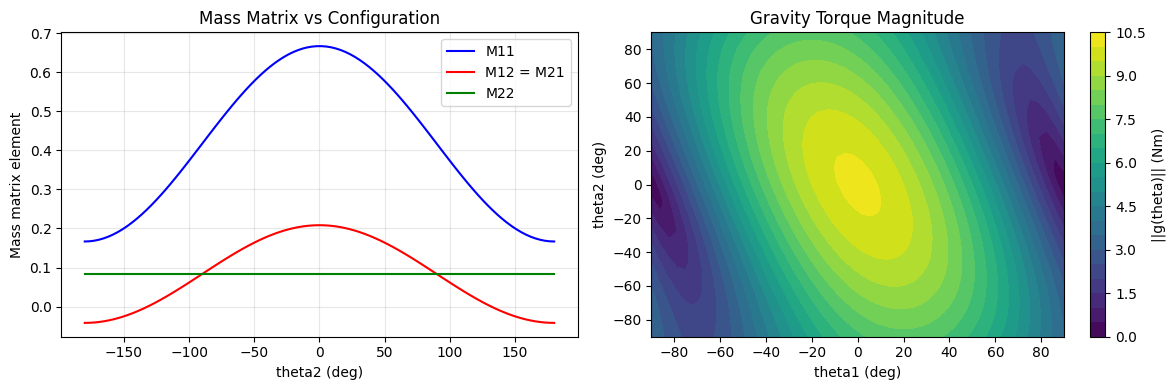

In [16]:
# Visualize how mass matrix changes with configuration
theta2_range = np.linspace(-np.pi, np.pi, 100)
M11 = []
M12 = []
M22 = []

for th2 in theta2_range:
    M = model.mass_matrix(np.array([0, th2]))
    M11.append(M[0, 0])
    M12.append(M[0, 1])
    M22.append(M[1, 1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(np.degrees(theta2_range), M11, 'b-', label='M11')
ax.plot(np.degrees(theta2_range), M12, 'r-', label='M12 = M21')
ax.plot(np.degrees(theta2_range), M22, 'g-', label='M22')
ax.set_xlabel('theta2 (deg)')
ax.set_ylabel('Mass matrix element')
ax.set_title('Mass Matrix vs Configuration')
ax.legend()
ax.grid(True, alpha=0.3)

# Gravity torques at different configurations
theta1_range = np.linspace(-np.pi/2, np.pi/2, 50)
theta2_range = np.linspace(-np.pi/2, np.pi/2, 50)
T1, T2 = np.meshgrid(theta1_range, theta2_range)
G_norm = np.zeros_like(T1)

for i in range(len(theta1_range)):
    for j in range(len(theta2_range)):
        g = model.gravity_vector(np.array([theta1_range[i], theta2_range[j]]))
        G_norm[j, i] = np.linalg.norm(g)

ax = axes[1]
c = ax.contourf(np.degrees(T1), np.degrees(T2), G_norm, levels=20, cmap='viridis')
plt.colorbar(c, ax=ax, label='||g(theta)|| (Nm)')
ax.set_xlabel('theta1 (deg)')
ax.set_ylabel('theta2 (deg)')
ax.set_title('Gravity Torque Magnitude')

plt.tight_layout()
plt.show()